# Training Covariance model
##### Tested on kernel `TensorFow on GPU` as defined in the image `landerlini/lhcbaf:v0p8`

This notebook is part of a pipeline. It requires the preprocessing step defined in the 
[GAN preprocessing notebook](./Preprocessing-GANs.ipynb) and the trained model is 
validated in the [Covariance-validation](./Covariance-validation.ipynb) notebook.

### Environment and libraries
As for the other trainings, we are handling the GPU with TensorFlow.
To make sure the GPU is found, we print below the system name of the accelerator.

In [1]:
import numpy as np 
import pandas as pd 
import dask.dataframe as ddf
import os
from os import environ

## Remove annoying warnings 
environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

print ("GPU:", tf.test.gpu_device_name())

GPU: 


## Loading the data

The data are loaded with our custom `FeatherReader` helper class, defined in the local module [`feather_io`](./feather_io.py).

In this notebook, we are using:
 * *training data*: to optimize the weights of the network
 * *validation data*: to evaluate overtraining effects

In [2]:
from feather_io import FeatherReader    

ds_train = FeatherReader(environ.get("TRAIN_DATA", "covariance-train")).as_tf_dataset()
ds_val = FeatherReader(environ.get("VALIDATION_DATA", "covariance-validation")).as_tf_dataset()

A chunk of data is loaded to ease the construction of the model, for example defining the shapes of the input and output tensors.

In [3]:
X, y = next(iter(ds_train.batch(1_000_000)))
X.shape, y.shape

(TensorShape([1000000, 16]), TensorShape([1000000, 15]))

## Visualization of the correlations of the input features (conditions)

High correlation of the input features may result in large distances between the distributions of the trained and generated dataset with minimal overlap. In this conditions, the discriminator would be unable to drive the training of the generator towards a successful end (unless more advanced loss functions are used).

Since we adopted a rather sophisticated preprocessing step, it is worth verifying that it behaves as expected, clearing strong correlations between variables.

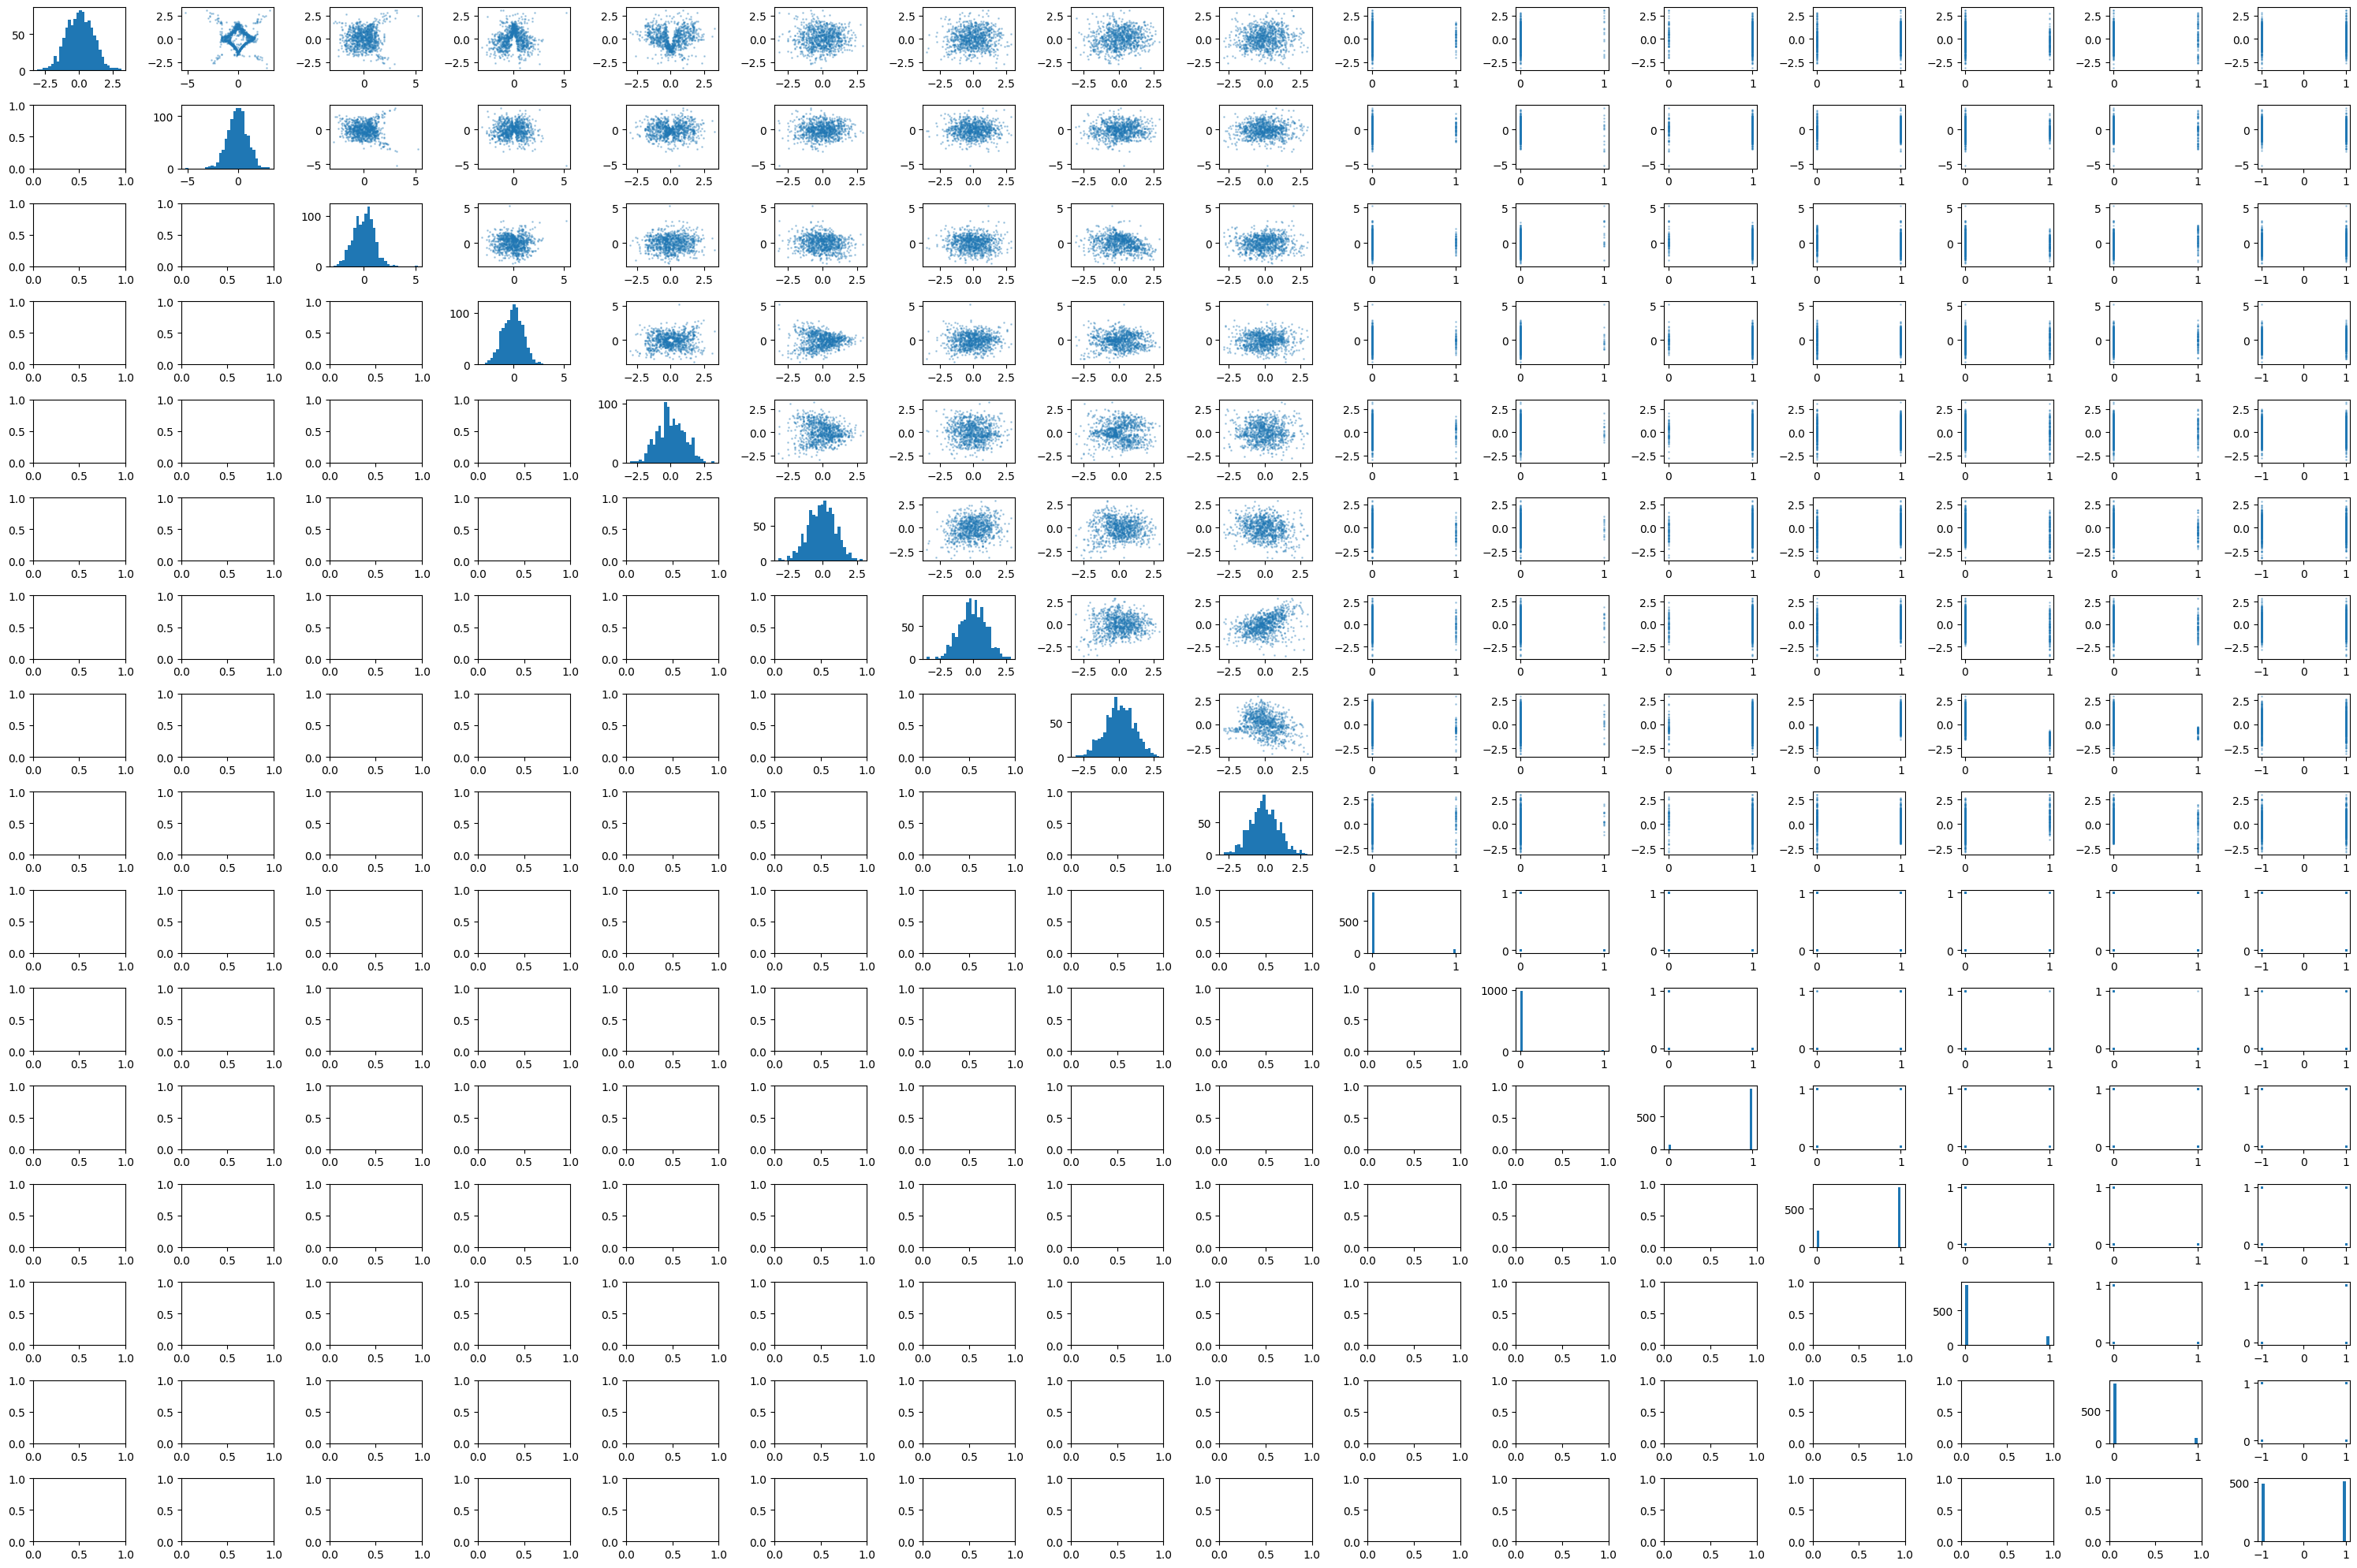

In [4]:
import matplotlib.pyplot as plt
X, y = next(iter(ds_train.batch(1_000)))
X = X.numpy()

nX = X.shape[1]

plt.figure(figsize=(30,20))
for iVar, x_i in enumerate(X.T, 1):
    for jVar, x_j in enumerate(X.T, 1):
        plt.subplot(nX, nX, nX*(iVar-1) + jVar)
        if iVar == jVar:
            plt.hist(x_i, bins=30)
        elif iVar < jVar:
            plt.scatter(x_j, x_i, s=1, alpha=0.3)
plt.tight_layout()
        
plt.show()

## Definition of the model
The GANs used in this module are composed of three different neural networks trained simultaneously, namely:
 * a *generator* neural network that takes as an input the *condition* (such as the generator-level features) and the *random noise* and formulate predictions for the output
 * a *discriminator* neural network trained to identify whether a sample was part of the reference dataset or was produced by the generator
 * a *referee* network that mimics the configuration of the discriminator, is trained with a much larger learning rate.

For a discussion on the techniques used to describe the GAN, please refer to the [resolution notebook](./Resolution.ipynb).

In [5]:
g_nLayers = 8
d_nLayers = 6
r_nLayers = 6

### Generator architecture
The generator architecture is very similar to the one adopted for the [resolution GAN](./Resolution.ipynb).

In [6]:
from pidgan.players.generators import ResGenerator

generator = ResGenerator(
    output_dim=y.shape[1],
    latent_dim=128,
    num_hidden_layers=g_nLayers,
    mlp_hidden_units=128,
    mlp_dropout_rates=0.0,
    output_activation=None,
    name="generator",
)

In [7]:
generator(X[:256])
generator.summary()

Model: "generator_func"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 144)]                0         []                            
                                                                                                  
 dense_0 (Dense)             (None, 128)                  18560     ['input_1[0][0]']             
                                                                                                  
 leaky_relu_0 (LeakyReLU)    (None, 128)                  0         ['dense_0[0][0]']             
                                                                                                  
 dropout_0 (Dropout)         (None, 128)                  0         ['leaky_relu_0[0][0]']        
                                                                                     

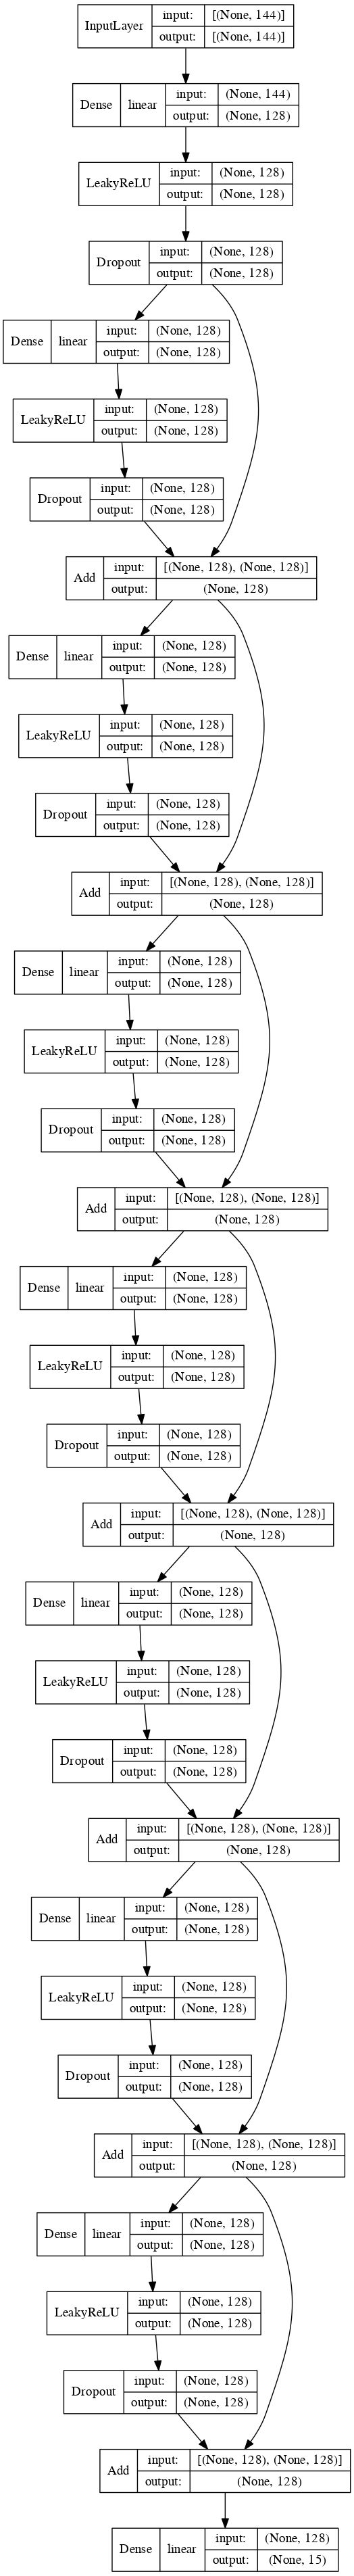

In [8]:
tf.keras.utils.plot_model(
    generator.export_model,
    to_file="./images/covariance-generator.png",
    show_shapes=True,
    show_layer_names=False,
    show_layer_activations=True,
    rankdir="TB",
    dpi=100,
)

### Discriminator architecture

Please note that we observe better performance using shallower neural networks and removing the skip connections for the discriminator. It is not clear why, but it is possible that the classification problem is so different from a logistic regression (for example because of the large number of flags) that propagating the input to the output is not beneficial and limits the network ability to perform the classification.

As for the [resolution GAN](./Resolution.ipynb), the input tensor is as follows.

<table width=300>
    <tr><th colspan=2>$X$<th><th>$y$</tr>
    <tr><td>Input conditions (gen. level features)<td><b>Reference</b> target features<td><td><b>1</b></tr>
    <tr><td>Input conditions (gen. level features)<td><b>Generated</b> target features<td><td><b>0</b></tr>
</table>

The input conditions are repeated twice, but in the first half of the batch 
they are completed with the output features of the reference samples and labeld as $1$.
In the second half of the batch they are completed with randomly generated features and labeld with $0$.


In [9]:
from pidgan.players.discriminators import ResDiscriminator

discriminator = ResDiscriminator(
    output_dim=1,
    num_hidden_layers=d_nLayers,
    mlp_hidden_units=128,
    mlp_dropout_rates=0.0,
    output_activation="sigmoid",
    name="discriminator",
)

In [10]:
discriminator((X[:256], y[:256]))
discriminator.summary()

Model: "discriminator_func"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 31)]                 0         []                            
                                                                                                  
 dense_0 (Dense)             (None, 128)                  4096      ['input_2[0][0]']             
                                                                                                  
 leaky_relu_0 (LeakyReLU)    (None, 128)                  0         ['dense_0[0][0]']             
                                                                                                  
 dropout_0 (Dropout)         (None, 128)                  0         ['leaky_relu_0[0][0]']        
                                                                                 

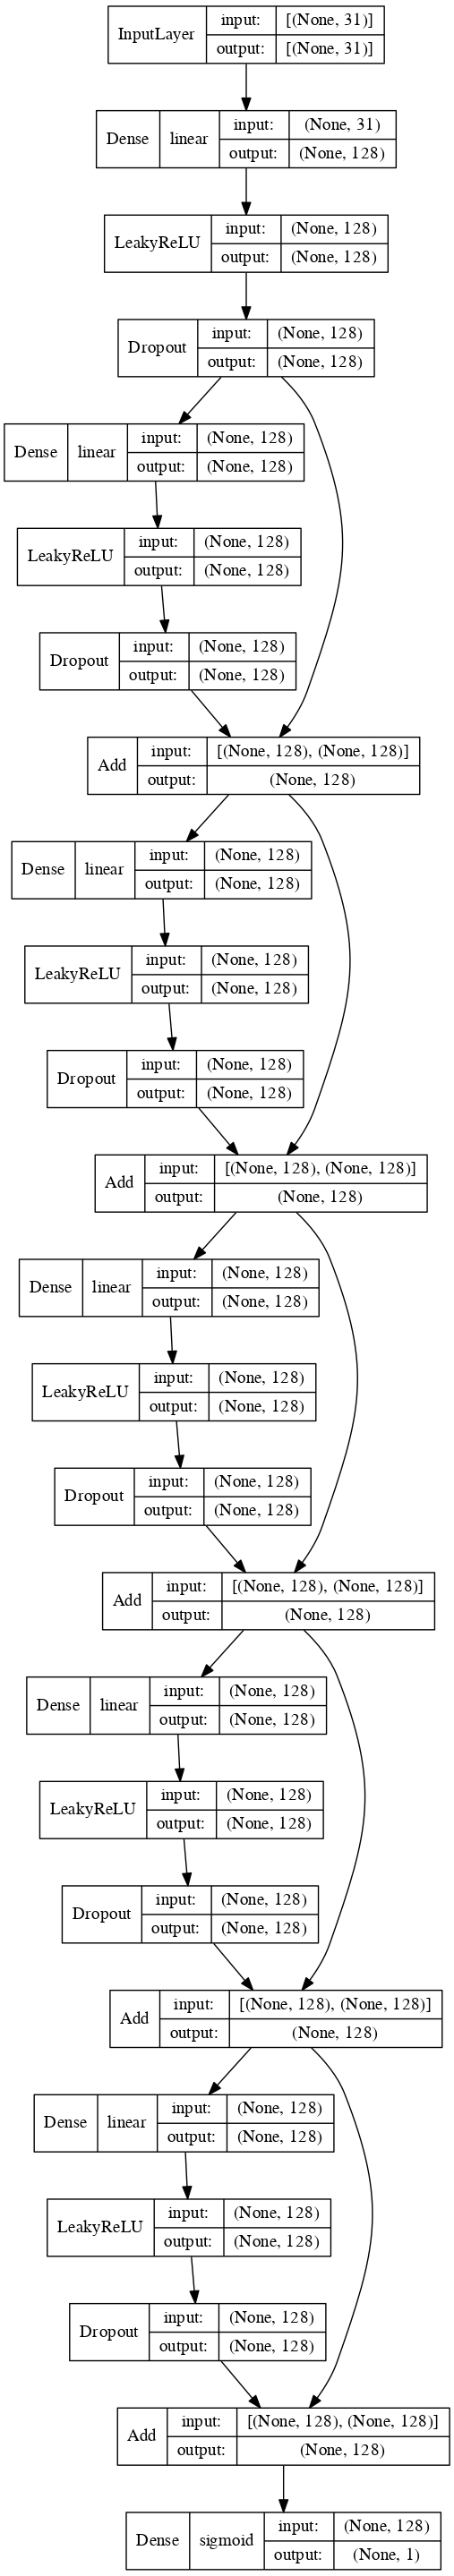

In [11]:
tf.keras.utils.plot_model(
    discriminator.export_model,
    to_file="./images/covariance-discriminator.png",
    show_shapes=True,
    show_layer_names=False,
    show_layer_activations=True,
    rankdir="TB",
    dpi=100,
)

### Referee architecture

The referee is kept as similar as possible to the discriminator, but trained with a larger learning rate.

In [12]:
from pidgan.players.classifiers import Classifier

referee = Classifier(
    num_hidden_layers=r_nLayers,
    mlp_hidden_units=128,
    mlp_hidden_activation="relu",
    mlp_hidden_kernel_regularizer=None,
    mlp_dropout_rates=0.0,
    name="referee",
)

In [13]:
referee((X[:256], y[:256]))
referee.summary()

Model: "referee_seq"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_0 (Dense)             (256, 128)                4096      
                                                                 
 dropout_0 (Dropout)         (256, 128)                0         
                                                                 
 dense_1 (Dense)             (256, 128)                16512     
                                                                 
 dropout_1 (Dropout)         (256, 128)                0         
                                                                 
 dense_2 (Dense)             (256, 128)                16512     
                                                                 
 dropout_2 (Dropout)         (256, 128)                0         
                                                                 
 dense_3 (Dense)             (256, 128)                

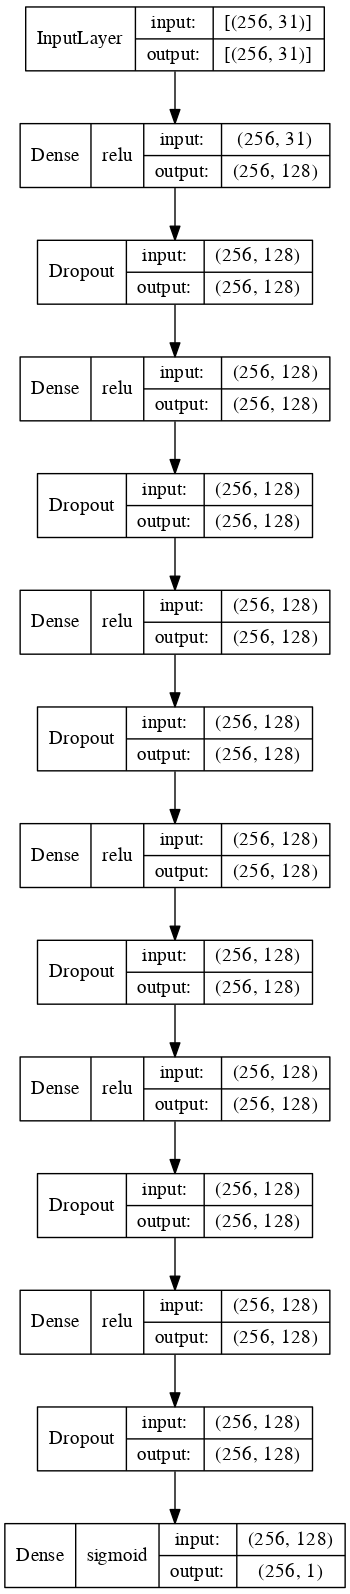

In [14]:
tf.keras.utils.plot_model(
    referee.export_model,
    to_file="./images/covariance-referee.png",
    show_shapes=True,
    show_layer_names=False,
    show_layer_activations=True,
    rankdir="TB",
    dpi=100,
)

### Training step

The training step is defined with the lower-level tensorflow API because we need to carefully
tune which weights we wish to update based on each evaluation of a loss function.

Technically, we are using the tensorflow [GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) 
to keep track of the gradient while we describe the computation of the loss function.
We will have a different tape for each neural network, recording the derivatives of the 
loss functions with respect to the weights of that particular network.

#### Notes on the chosen loss function
The loss function for the classification task is clearly a Binary Cross Entropy (BCE).
However we adopt two non-default options for its computation:
 * `from_logit=True`, to improve the numerical stability of the gradient computation, which
   is of particular importance for GANs because of the very long training procedure that 
   may inflate the errors due to many subsequent iterations
 * `label_smoothing=0.1`, to introduce a penalty against overconfident classification, which 
   corresponds to the *plateaux* of the sigmoid function, where the gradient is null, providing
   no useful information for the generator's training.


In [15]:
from pidgan.algorithms import BceGAN

gan = BceGAN(
    generator=generator,
    discriminator=discriminator,
    from_logits=False,
    label_smoothing=0.1,
    injected_noise_stddev=0.05,
    feature_matching_penalty=0.0,
    # referee=referee,  # uncomment for enabling referee net
)

In [16]:
from tensorflow.keras.optimizers import RMSprop, Adam

gan.compile(
    metrics=["accuracy", "js_div"],
    generator_optimizer=RMSprop(1e-4),
    discriminator_optimizer=RMSprop(2e-4),
    generator_upds_per_batch=1,
    discriminator_upds_per_batch=1,
    # referee_optimizer=Adam(1e-3),  # uncomment for enabling referee net
    # referee_upds_per_batch=1,  # uncomment for enabling referee net
)

In [17]:
from pidgan.callbacks.schedulers import LearnRateExpDecay

callbacks = list()

g_lr_sched = LearnRateExpDecay(
    gan.generator_optimizer,
    decay_rate=0.1,
    decay_steps=200_000,
    min_learning_rate=1e-6,
    verbose=True,
    key="g_lr",
)
callbacks.append(g_lr_sched)

d_lr_sched = LearnRateExpDecay(
    gan.discriminator_optimizer,
    decay_rate=0.1,
    decay_steps=150_000,
    min_learning_rate=5e-7,
    verbose=True,
    key="d_lr",
)
callbacks.append(d_lr_sched)

# r_lr_sched = LearnRateExpDecay(
#     gan.referee_optimizer,
#     decay_rate=0.1,
#     decay_steps=100_000,
#     verbose=True,
#     key="r_lr",
# )
# callbacks.append(r_lr_sched)  # uncomment for enabling referee net

## Training
 * Batch size: 10k
 * Number of epochs: 3000

In [18]:
batch_size = 7_500
num_epochs = 350

data_train = ds_train.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
data_val = next(iter(ds_val.batch(batch_size)))

train = gan.fit(data_train, epochs=num_epochs, validation_data=data_val, callbacks=callbacks)

Epoch 1/350


894/894 [==============================] - 63s 67ms/step - g_loss: 2.4529 - d_loss: 0.3698 - accuracy: 0.1058 - js_div: 0.6635 - g_lr: 9.9487e-05 - d_lr: 1.9863e-04 - val_g_loss: 1.8085 - val_d_loss: 0.3633 - val_accuracy: 0.1897 - val_js_div: 0.6097
Epoch 2/350
894/894 [==============================] - 54s 59ms/step - g_loss: 2.2577 - d_loss: 0.3788 - accuracy: 0.1372 - js_div: 0.6568 - g_lr: 9.8467e-05 - d_lr: 1.9592e-04 - val_g_loss: 1.5000 - val_d_loss: 0.4350 - val_accuracy: 0.3045 - val_js_div: 0.4420
Epoch 3/350
894/894 [==============================] - 54s 59ms/step - g_loss: 1.8121 - d_loss: 0.4519 - accuracy: 0.2167 - js_div: 0.4401 - g_lr: 9.7459e-05 - d_lr: 1.9325e-04 - val_g_loss: 1.8169 - val_d_loss: 0.4772 - val_accuracy: 0.1361 - val_js_div: 0.3898
Epoch 4/350
894/894 [==============================] - 54s 60ms/step - g_loss: 1.3303 - d_loss: 0.5456 - accuracy: 0.3283 - js_div: 0.2208 - g_lr: 9.6461e-05 - d_lr: 1.9062e-04 - val_g_loss: 1.2455 - val_d_loss: 0.5785 - va

The evolution of the loss function as evaluated by the referee network is reported below.
A dashed line represent the ideal value of the BCE when evaluated on two identical datasets with an ideal classifier.

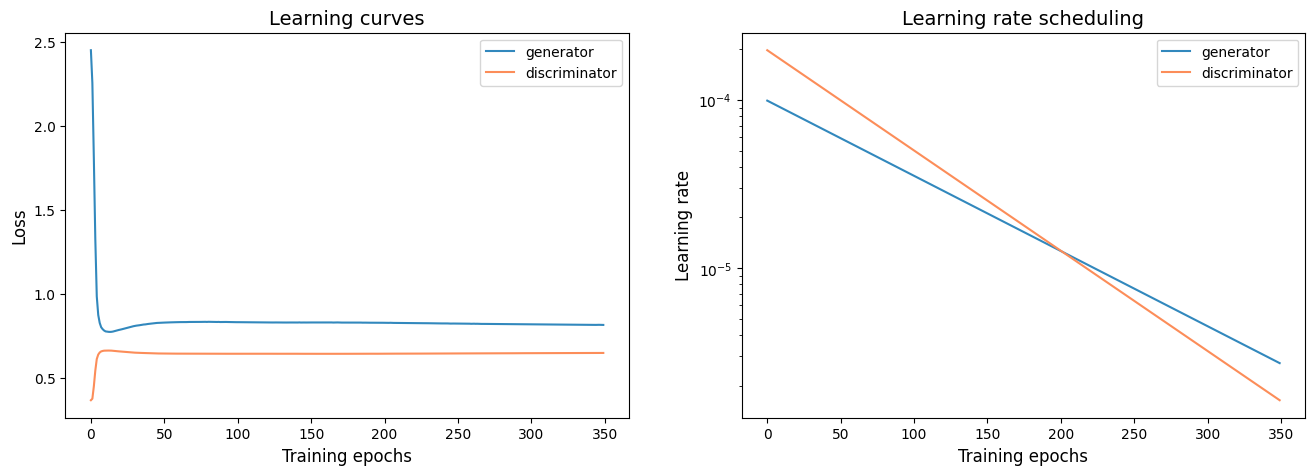

In [19]:
plt.figure(figsize=(16, 5), dpi=100)

plt.subplot(1, 2, 1)
plt.title("Learning curves", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.plot(train.history["g_loss"], color="#3288bd", label="generator")
plt.plot(train.history["d_loss"], color="#fc8d59", label="discriminator")
# plt.plot(train.history["r_loss"], color="#4dac26", label="referee")
plt.legend(loc="upper right", fontsize=10)

plt.subplot(1, 2, 2)
plt.title("Learning rate scheduling", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel("Learning rate", fontsize=12)
plt.plot(train.history["g_lr"], color="#3288bd", label="generator")
plt.plot(train.history["d_lr"], color="#fc8d59", label="discriminator")
# plt.plot(train.history["r_lr"], color="#4dac26", label="referee")
plt.legend(loc="upper right", fontsize=10)
plt.yscale("log")

plt.show()

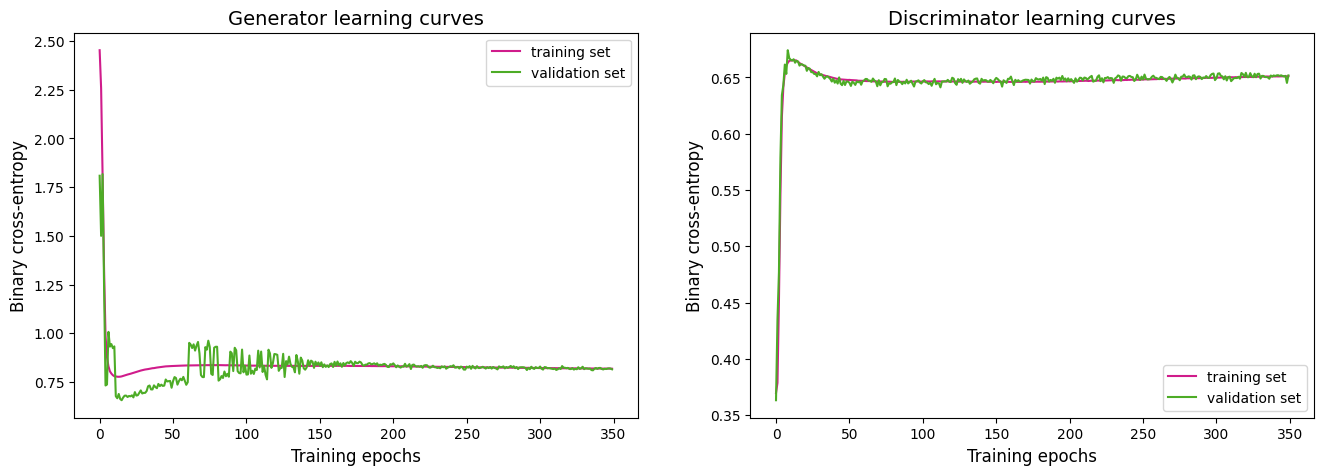

In [20]:
plt.figure(figsize=(16, 5), dpi=100)

plt.subplot(1, 2, 1)
plt.title("Generator learning curves", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel(gan.loss_name, fontsize=12)
plt.plot(train.history["g_loss"], color="#d01c8b", label="training set")
plt.plot(train.history["val_g_loss"], color="#4dac26", label="validation set")
plt.legend(loc="upper right", fontsize=10)

plt.subplot(1, 2, 2)
plt.title("Discriminator learning curves", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel(gan.loss_name, fontsize=12)
plt.plot(train.history["d_loss"], color="#d01c8b", label="training set")
plt.plot(train.history["val_d_loss"], color="#4dac26", label="validation set")
plt.legend(loc="lower right", fontsize=10)

plt.show()

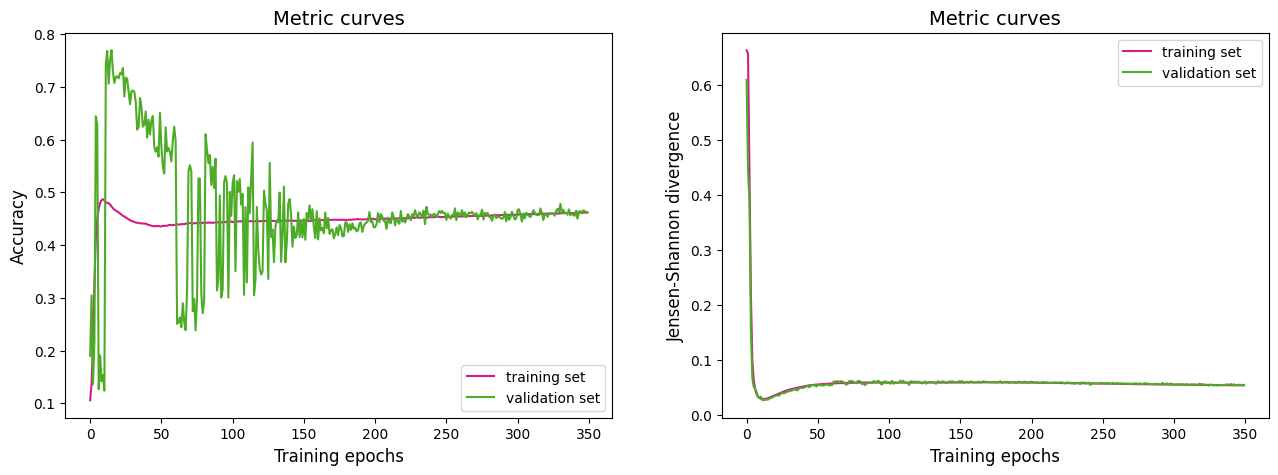

In [21]:
plt.figure(figsize=(24, 5), dpi=100)

plt.subplot(1, 3, 1)
plt.title("Metric curves", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.plot(train.history["accuracy"], color="#d01c8b", label="training set")
plt.plot(train.history["val_accuracy"], color="#4dac26", label="validation set")
plt.legend(loc="lower right", fontsize=10)

plt.subplot(1, 3, 2)
plt.title("Metric curves", fontsize=14)
plt.xlabel("Training epochs", fontsize=12)
plt.ylabel("Jensen-Shannon divergence", fontsize=12)
plt.plot(train.history["js_div"], color="#d01c8b", label="training set")
plt.plot(train.history["val_js_div"], color="#4dac26", label="validation set")
plt.legend(loc="upper right", fontsize=10)

# plt.subplot(1, 3, 3)
# plt.title("Referee learning curves", fontsize=14)
# plt.xlabel("Training epochs", fontsize=12)
# plt.ylabel("Binary cross-entropy", fontsize=12)
# plt.plot(train.history["r_loss"], color="#d01c8b", label="training set")
# plt.plot(train.history["val_r_loss"], color="#4dac26", label="validation set")
# plt.legend(loc="lower right", fontsize=10)

plt.show()

In [22]:
train_history = train.history.copy()
pd.DataFrame(train_history).to_csv("./exports/covariance-train.csv")

## Sanity check
In the following plot we represent the correlation between the output features as they are in the reference dataset 
and as they are reproduced by the GAN.

The <font color="#08c">original dataset</font> is represented in <font color="#08c">blue</font>, while the <font color="#c80"> generated dataset in orange</font>.

In [23]:
# X, y = next(iter(ds_train.batch(1_000)))
# y = y.numpy()
# y_hat = gan.generator.predict(X, batch_size=50_000)
# d = discriminator.predict((X, y, y_hat))
# 
# 
# nY = y.shape[1]
# 
# plt.figure(figsize=(30,20))
# for iVar, y_i in enumerate(y.T, 1):
#     for jVar, y_j in enumerate(y.T, 1):
#         plt.subplot(nY, nY, nX*(iVar-1) + jVar)
#         if iVar == jVar:
#             plt.hist(y_i, bins=30)
#         elif iVar < jVar:
#             plt.scatter(y_j, y_i, s=1, alpha=0.6)
#             
#             
# for iVar, y_i in enumerate(y_hat.T, 1):
#     for jVar, y_j in enumerate(y_hat.T, 1):
#         plt.subplot(nY, nY, nX*(iVar-1) + jVar)
#         if iVar == jVar:
#             plt.hist(y_i, bins=30, histtype='step', linewidth=2)
#         elif iVar < jVar:
#             plt.scatter(y_j, y_i, s=1, alpha=0.3)
#         elif iVar > jVar:
#             
#             plt.scatter(y_j, y_i, s=3, c=d[1000:], alpha=0.3, cmap='seismic')
#         
# plt.tight_layout()
#         
# plt.show()

## Exporting the model
The model is exported to the same directory were the preprocessing steps `tX` and `tY` were stored.

In [24]:
reader_test = FeatherReader(environ.get("TRAIN_DATA", "covariance-test"), max_files=20)
head = reader_test.as_dask_dataframe().head(20_000_000, npartitions=-1)

X_test = head[reader_test.features].values
y_test = head[reader_test.labels].values
preds = gan.generator.predict(X_test, batch_size=50_000)

108/108 [==============================] - 5s 40ms/step


In [25]:
X_test.shape, y_test.shape, preds.shape

((5369449, 16), (5369449, 15), (5369449, 15))

In [26]:
import pickle

x_fname = "/home/mabarbet/PythonFastSim/models/lb-trksim-train/covariance/tX.pkl"
with open(x_fname, "rb") as file:
    X_scaler = pickle.load(file)

y_fname = "/home/mabarbet/PythonFastSim/models/lb-trksim-train/covariance/tY.pkl"
with open(y_fname, "rb") as file:
    y_scaler = pickle.load(file)

In [27]:
from pidgan.utils.preprocessing import invertColumnTransformer

for track in ["long", "upstream", "downstream"]:
    query_index = reader_test.features.index(track)
    query = X_test[:, query_index] == 1
    print(f"Shape for {track}:", X_test[query].shape, y_test[query].shape, preds[query].shape)
    
    X_post = invertColumnTransformer(X_scaler, X_test[query])[:, :6]
    y_post = invertColumnTransformer(y_scaler, y_test[query])
    preds_post = invertColumnTransformer(y_scaler, preds[query])

    results = np.c_[X_post, y_post, preds_post][:450_000]
    # results = np.c_[y_post, preds_post][:550_000]
    # print(results.shape)

    np.savez_compressed(
        f"./exports/covariance-results-{track}.npz",
        feat_vars=[c.replace("true", "mc") for c in reader_test.features[:6]],
        label_vars=reader_test.labels,
        results=results,
    )

Shape for long: (4231436, 16) (4231436, 15) (4231436, 15)
Shape for upstream: (651211, 16) (651211, 15) (651211, 15)
Shape for downstream: (486806, 16) (486806, 15) (486806, 15)


In [28]:
import os
default_output_model = "/home/mabarbet/PythonFastSim/models/lb-trksim-train/covariance"
output_model = os.path.dirname(environ['OUTPUT_MODEL']) if 'OUTPUT_MODEL' in environ else default_output_model
base_dir = os.path.dirname(output_model)
if not os.path.exists(base_dir):
    os.mkdir(base_dir)
generator.save(output_model)

INFO:tensorflow:Assets written to: /home/mabarbet/PythonFastSim/models/lb-trksim-train/covariance/assets


INFO:tensorflow:Assets written to: /home/mabarbet/PythonFastSim/models/lb-trksim-train/covariance/assets


## Conclusion
In this notebook we discussed the training procedure of the GAN model used to parametrize the covariance.
The model is very similar to the one adopted for the resolution, with some difference in the architecture of the discriminator and referee networks.

In particular, we discussed
 * the overall structure of the DNN system;
 * the architecture of the generator, discriminator and of a referee network we introduced to ease monitoring, debugging an hyperparameter optimization
 * the procedure for optimizing the weights of the three networks based on three different computations of the gradients
 * the outcome of the training procedure as visualized by the evolution of the loss of the referee network

Finally, we exported the model for deployment and further validation.
